# Implementation of a comparison of COMPAS data across all fairness functions

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid, load_dataset, mean_difference
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean, plot_median
from src.training import train
from src.distribution import ResamplingDistribution, AdultCreditDistribution

unable to import 'smart_open.gcs', disabling that module


## Uncalibrated Score: Benefit Difference: Benefit Difference

In [2]:
def calc_benefit(decisions, y, ips_weights):
    benefit = demographic_parity(decisions=decisions, y=y)

    if ips_weights is not None:
        benefit *= ips_weights

    return benefit

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)

    log_gradient = policy.log_policy_gradient(x, s)
    benefit_grad = log_gradient * benefit
        
    return mean_difference(benefit_grad, s)

def fairness_function(**fairness_kwargs):
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)
        
    return mean_difference(benefit, s)

bias = True
# distribution = ResamplingDistribution(bias=bias, dataset=load_dataset("../dat/compas/compas.npz"), test_percentage=0.2)
distribution = AdultCreditDistribution(bias=bias, test_percentage=0.2)
dim_theta = distribution.feature_dim

print(dim_theta)

def util_func(**util_params):
    util = cost_utility(cost_factor=0.6, **util_params)
    return util

training_parameters = {    
    'model':{
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': np.zeros((dim_theta))
    },
    'distribution': distribution,
    'parameter_optimization': {
        'time_steps':20,
        'epochs': 40,
        'batch_size':64,
        'learning_rate': 0.1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_batches': 64,
        'fix_seeds': True
    },
    'test': {
        'num_samples': None
    }
}

75


In [3]:
training_parameters["save_path"] = "./exp-019-adult-no-fairness"
training_parameters["model"]["initial_lambda"] = 0.0

statistics, _, run_path = train(training_parameters, iterations=5, asynchronous=True)

plot_mean(statistics, "{}/results_mean_time.png".format(run_path))
plot_median(statistics, "{}/results_median_time.png".format(run_path))

## STARTED Single training run // LR = 0.1 // TS = 20 // E = 40 // BS = 64 // NB = 64 ##
## ENDED Single training run // LR = 0.1 // TS = 20 // E = 40 // BS = 64 // NB = 64 ##


---------- Training with fixed lambdas ----------


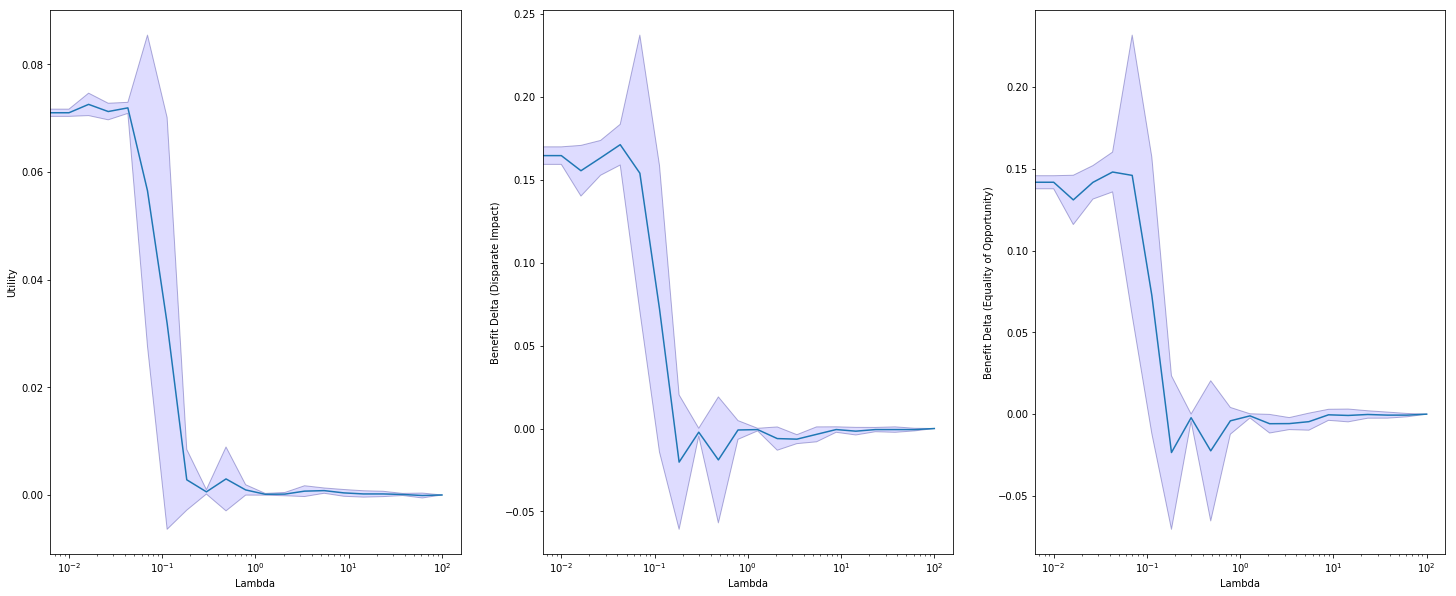

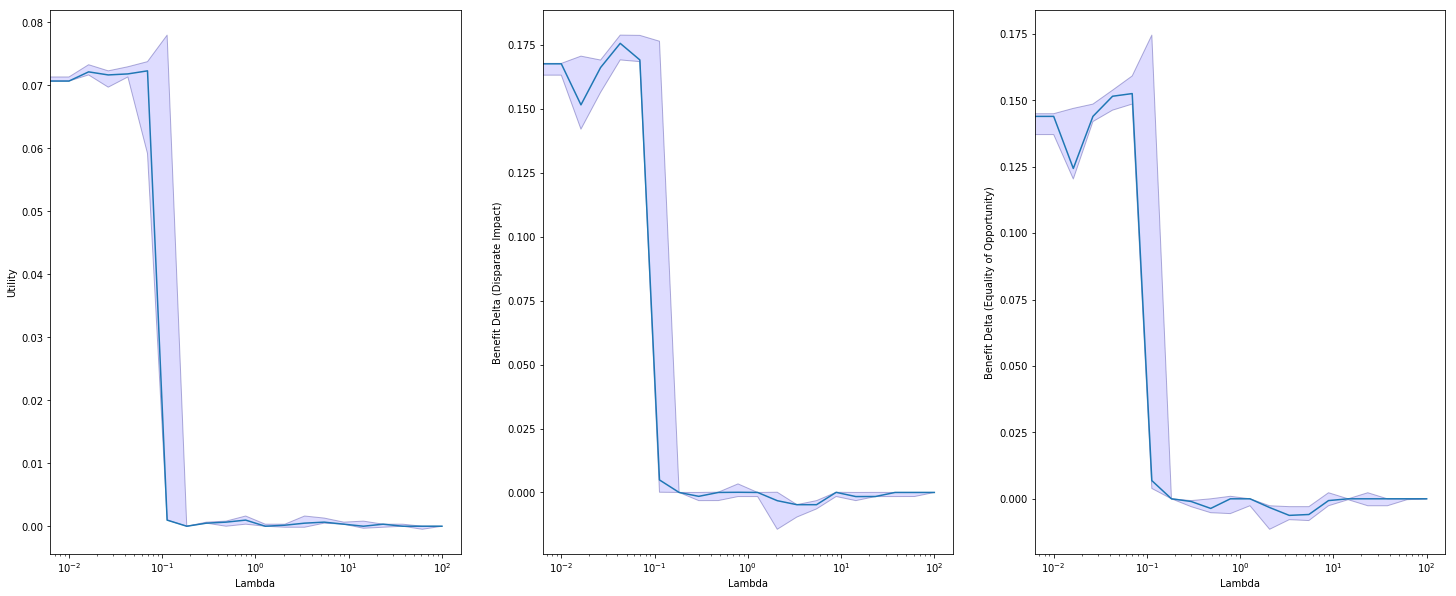

In [13]:
training_parameters["save_path"] = "./exp-019-adult-benefit-lambda-sweep"
lambdas = np.logspace(-2, 2, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, model_parameters, run_path = train(training_parameters, iterations=5, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


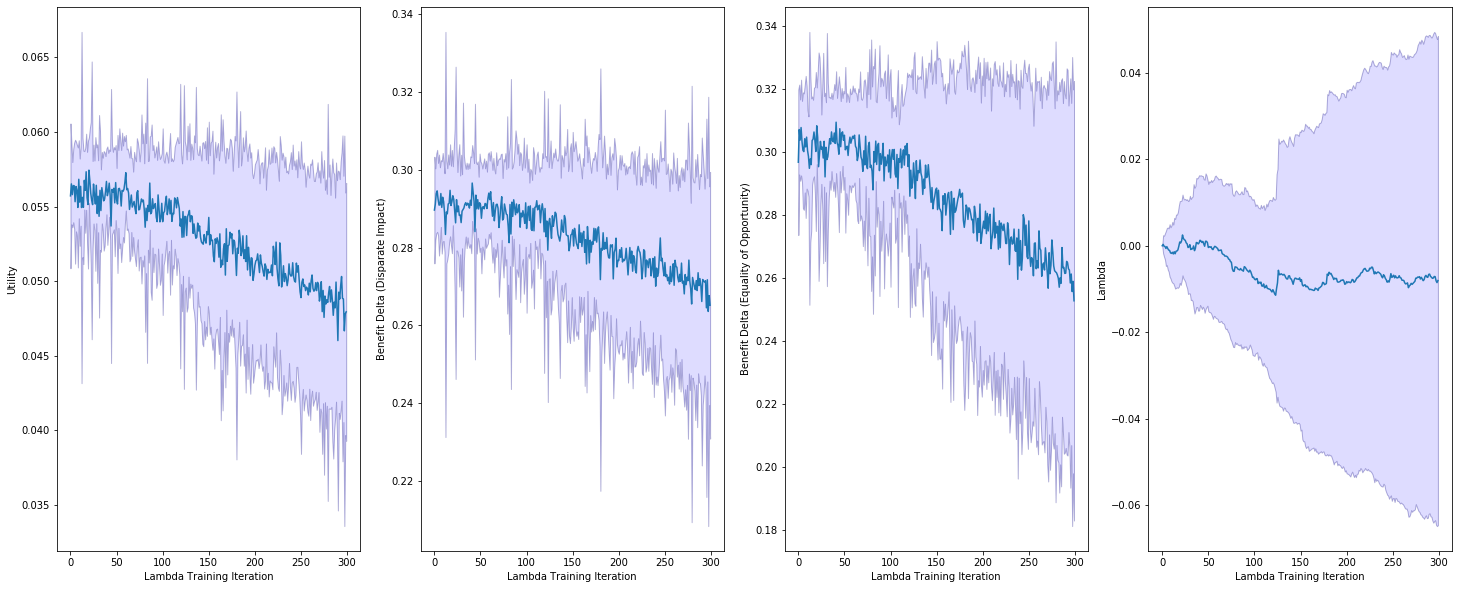

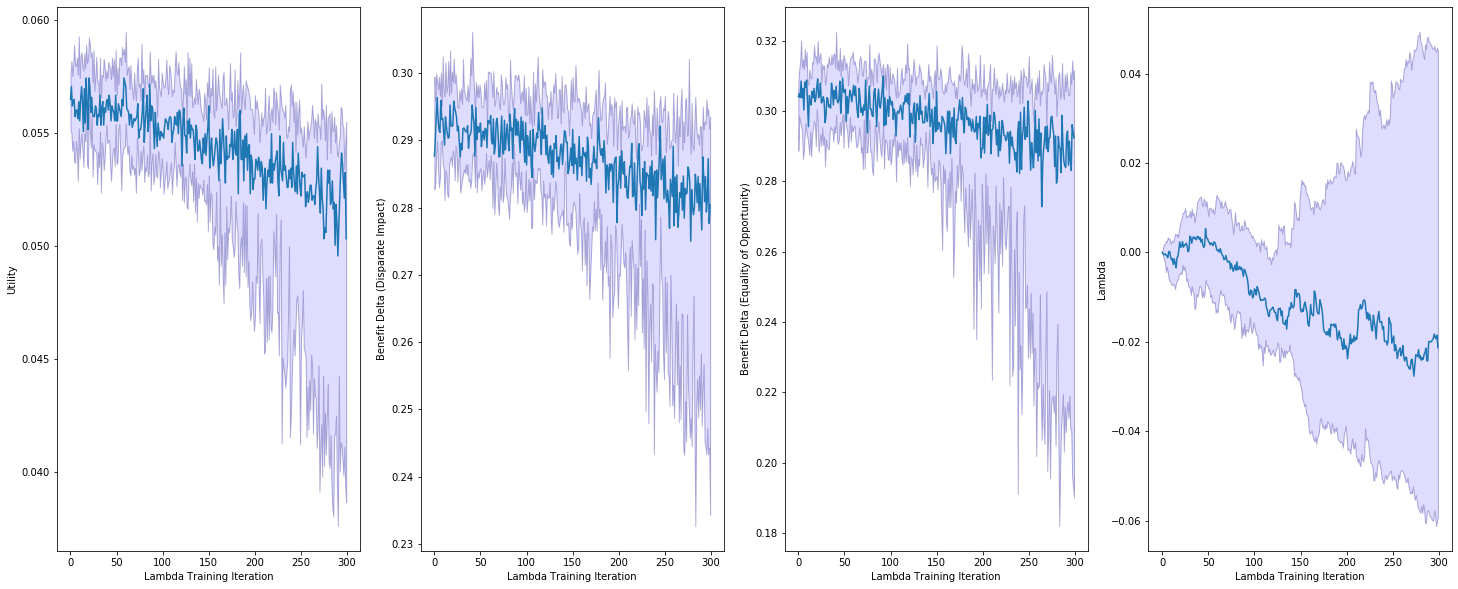

In [6]:
training_parameters["save_path"] = "./exp-019-adult-benefit-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 300,
    'epochs': 1,
    'batch_size':256,
    'learning_rate': 0.01,
    'decay_rate': 1,
    'decay_step': 1000000,
    'num_decisions': 128 * 512
}

statistics, model_parameters, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)
